# Introduction to Machine Learning in python

In [1]:
from parameters import Parameters
from model import initial_values, fedbatch, feed_values
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np

## Use the " Big data generator" to generate data !

In [2]:
def random_feedstock(i):
    np.random.seed = i
    # Name     Value     Index     Units
    Glu0_mu  =  39.7        # 1       g/L
    Glu0_sigma = Glu0_mu*0.25
    Glu0 = np.random.normal(loc=Glu0_mu, scale=Glu0_sigma)
    Xyl0_mu  =  23.5        # 2       g/L
    Xyl0_sigma = Xyl0_mu*0.25
    Xyl0 = np.random.normal(loc=Xyl0_mu, scale=Xyl0_sigma)
    
    ## fixed inhibitor to glucose ratio
    Fur0  =  0.56   *(Glu0/Glu0_mu)        # 3       g/L
    FA0   =  0      *(Glu0/Glu0_mu)        # 4       g/L
    HMF0  =  0.2    *(Glu0/Glu0_mu)        # 5       g/L
    HAc0  =  3.05   *(Glu0/Glu0_mu)        # 6       g/L
    # Ac0   =  0.0001;    # 7       g/L
    EtOH0 =  0.62        # 7       g/L
    X0    =  1.75        # 8       g/L
    V0    = 0.7          # 9       g/L
    
    init = [Glu0, Xyl0, Fur0, FA0, HMF0, HAc0, EtOH0, X0, V0]
    return init

In [3]:
def subplot(sol, par, fig, axs):
    '''plot the results in a subplot with one subplot for each component'''
    fig.suptitle(f'Fedbatch with random feedstock composition')
    axs[0,0].plot(sol.t, sol.y[0,:])
    axs[0,0].set(ylabel='Glucose [g/L]')
    axs[0,1].plot(sol.t, sol.y[1,:])
    axs[0,1].set(ylabel='Xylose [g/L]')
    axs[1,0].plot(sol.t, sol.y[2,:])
    axs[1,0].set(ylabel='Furfural [g/L]')
    axs[1,1].plot(sol.t, sol.y[3,:])
    axs[1,1].set(ylabel='Furfuryl alcohol [g/L]')
    axs[2,0].plot(sol.t, sol.y[4,:])
    axs[2,0].set(ylabel='5-HMF [g/L]')
    axs[2,1].plot(sol.t, sol.y[5,:])
    axs[2,1].set(ylabel='HAc [g/L]')
    axs[3,0].plot(sol.t, sol.y[6,:])
    axs[3,0].set(ylabel='Ethanol [g/L]', xlabel='Time [h]')
    axs[3,1].plot(sol.t, sol.y[7,:])
    axs[3,1].set(ylabel='Biomass [g/L]', xlabel='Time [h]')
    fig.tight_layout()
    plt.savefig('random.png')

<class 'numpy.ndarray'>


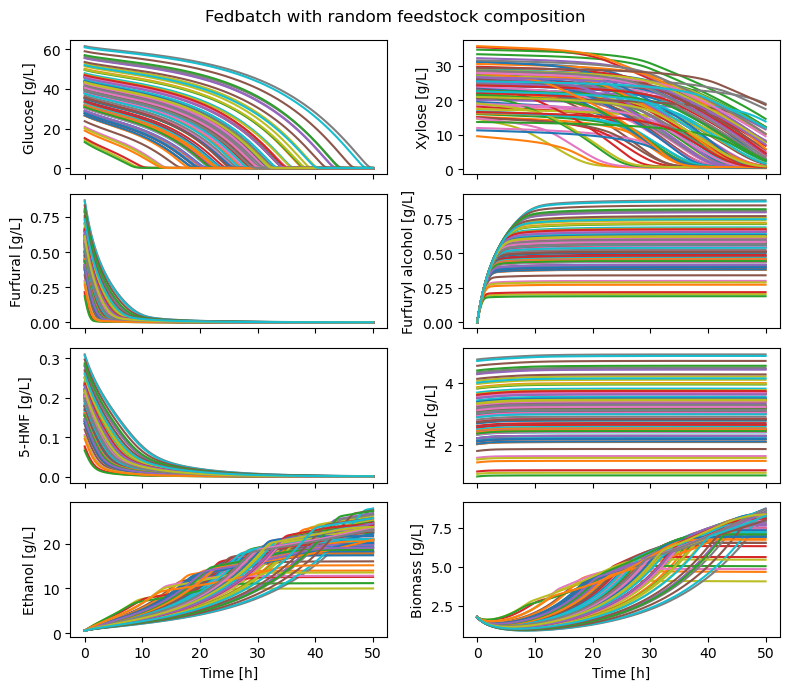

In [4]:
fig, axs = plt.subplots(nrows=4, ncols=2, sharex=True, figsize=(8,7))
n = 100
par = Parameters()
input = np.zeros((2,n))
output = []
count = 0
for i in range(n):
    init = random_feedstock(i)
    input[0,i] = init[0]            # Store input values for later
    input[1,i] = init[1]
    Cfeed = feed_values(init)
    tspan = (0,50)
    sol = solve_ivp(fedbatch, t_span=tspan, y0=init, args=(par,Cfeed,), method='LSODA', rtol=1e-8, atol=1e-8)
    subplot(sol, par, fig, axs)
    output.append(sol.y[2,-1] < 0.0005) # Store output for later, here, you can choose your own output :) 
print(type(Cfeed))

## Arrange the generated data in a pandas DataFrame:

In [5]:
import seaborn as sns
import pandas as pd

In [6]:
data = pd.DataFrame()
data['0'] = output
data['1'] = input[0,:]
data['2'] = input[1,:]
data # .sum(), .mean(), .fillna(), etc.


,0,1,2
0,True,30.874205,27.078229
1,True,28.026791,22.230045
2,True,40.356965,33.300884
3,True,34.114377,21.907094
4,False,55.514076,22.646988
...,...,...,...
95,False,53.593947,29.342327
96,True,40.582207,27.890176
97,True,39.421788,28.569399
98,True,43.464882,20.908853


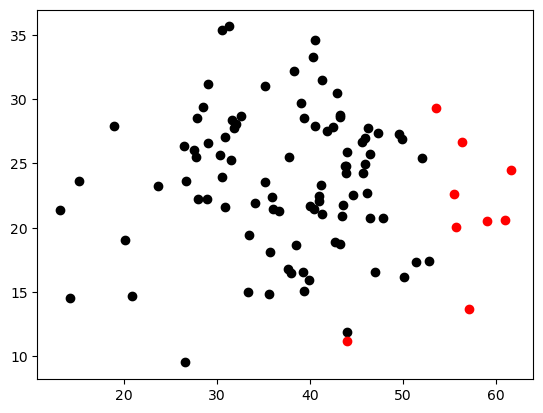

In [7]:
def color(result):
    if result:
        return 'k'
    else:
        return 'r'
[plt.scatter(data['1'].loc[i], data['2'].loc[i], color= color(data['0'].loc[i])) for i in range(n)]

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


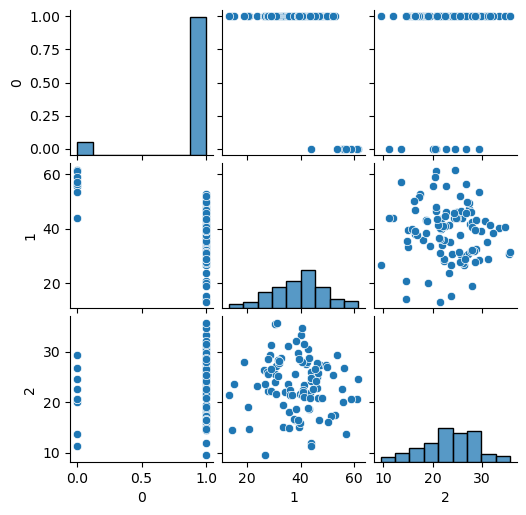

In [8]:
g = sns.pairplot(data)
g.fig.set_size_inches(5,5)

## **Classification**

In [9]:
X = np.array(data.drop('0', axis=1))
Y = np.array(data['0'])
Y

array([ True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
       False,  True, False,  True,  True, False,  True,  True,  True,
        True])

In [10]:
print(X.shape)
print(Y.shape)

(100, 2)
(100,)


### Decision Tree

In [11]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

clf = DecisionTreeClassifier().fit(X_train, y_train) # defining the model object and fitting in ONE STEP
y_train_pred = clf.predict(X_train)
probY_pred = clf.predict_proba(X_train)

In [12]:
confusion_matrix(y_train, y_train_pred)

array([[ 5,  0],
       [ 0, 65]], dtype=int64)

In [13]:
y_test_pred = clf.predict(X_test)
confusion_matrix(y_test, y_test_pred)

array([[ 3,  1],
       [ 0, 26]], dtype=int64)

In [14]:
print(tree.export_text(clf))

|--- feature_0 <= 53.17
|   |--- class: True
|--- feature_0 >  53.17
|   |--- class: False

